print("hello")

In [4]:
print("hello")

hello


For this lab, let's us the following libraries:

- [`torch`](https://pytorch.org/): The core library for building and training neural network models in this project, including the implementation of Self-Attention mechanisms and Positional Encodings.
- [`torch.nn`](https://pytorch.org/docs/stable/nn.html), [`torch.nn.functional`](https://pytorch.org/docs/stable/nn.functional.html): These PyTorch submodules are used to define the neural network layers and apply functions such as activations, which are essential in building the model architecture.
- [`Levenshtein`](https://pypi.org/project/python-Levenshtein/): This library is used for calculating the Levenshtein distance, which can be useful for evaluating model performance in tasks like text generation or translation by measuring the difference between the predicted and actual text sequences.
- [`get_tokenizer`](https://pytorch.org/text/stable/data_utils.html), [`build_vocab_from_iterator`](https://pytorch.org/text/stable/vocab.html) from `torchtext`: These functions are crucial for preprocessing text data, including tokenizing text into words or subwords and building a vocabulary from the dataset, which are foundational steps in preparing data for NLP models.


In [2]:
# Install packages
! pip install Levenshtein
#! pip install matplotlib
!pip install torch==2.3.0 torchtext==0.18.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 814.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 800.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.21.5
    Uninstalling nvidia-nccl-cu12-2.21.5:
      Successfully uninstalled nvidia-nccl-cu12-2.21.5
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 9.

In [3]:
import os
import sys
import time
import warnings
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests

from Levenshtein import distance
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

/usr/local/lib/python3.11/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

In [5]:
# Device for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
split = 'train'

# Training parameters
learning_rate = 3e-4
batch_size = 64
max_iters = 5000              # Maximum training iterations
eval_interval = 200           # Evaluate model every 'eval_interval' iterations in the training loop
eval_iters = 100              # When evaluating, approximate loss using 'eval_iters' batches

# Architecture parameters
max_vocab_size = 256          # Maximum vocabulary size
vocab_size = max_vocab_size   # Real vocabulary size (e.g. BPE has a variable length, so it can be less than 'max_vocab_size')
block_size = 16               # Context length for predictions
n_embd = 32                   # Embedding size
num_heads = 2                 # Number of head in multi-headed attention
n_layer = 2                   # Number of Blocks
ff_scale_factor = 4           # Note: The '4' magic number is from the paper: In equation 2 uses d_model=512, but d_ff=2048
dropout = 0.0                 # Normalization using dropout# 10.788929 M parameters

head_size = n_embd // num_heads
assert (num_heads * head_size) == n_embd

In [6]:
def plot_embdings(my_embdings,name,vocab):

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')

  # Plot the data points
  ax.scatter(my_embdings[:,0], my_embdings[:,1], my_embdings[:,2])

  # Label the points
  for j, label in enumerate(name):
      i=vocab.get_stoi()[label]
      ax.text(my_embdings[j,0], my_embdings[j,1], my_embdings[j,2], label)

  # Set axis labels
  ax.set_xlabel('X Label')
  ax.set_ylabel('Y Label')
  ax.set_zlabel('Z Label')

  # Show the plot
  plt.show()

In [7]:
dictionary = {
    'le': 'the'
    , 'chat': 'cat'
    , 'est': 'is'
    , 'sous': 'under'
    , 'la': 'the'
    , 'table': 'table'
}

In [8]:
# Create and sort the input vocabulary from the dictionary's keys
vocabulary_in = sorted(list(set(dictionary.keys())))
# Display the size and the sorted vocabulary for the input language
print(f"Vocabulary input ({len(vocabulary_in)}): {vocabulary_in}")

# Create and sort the output vocabulary from the dictionary's values
vocabulary_out = sorted(list(set(dictionary.values())))
# Display the size and the sorted vocabulary for the output language
print(f"Vocabulary output ({len(vocabulary_out)}): {vocabulary_out}")

Vocabulary input (6): ['chat', 'est', 'la', 'le', 'sous', 'table']
Vocabulary output (5): ['cat', 'is', 'table', 'the', 'under']


 - The tokenize function is responsible for breaking down a sentence into individual words.
 - The translate function uses this tokenize function to split the input sentence and then translates each word according to the dictionary. The translated words are concatenated to form the output sentence.

In [9]:
# Function to convert a list of vocabulary words into one-hot encoded vectors
def encode_one_hot(vocabulary):
    vocabulary_size = len(vocabulary)  # Get the size of the vocabulary
    one_hot = dict()  # Initialize a dictionary to hold our one-hot encodings
    LEN = len(vocabulary)  # The length of each one-hot encoded vector will be equal to the vocabulary size

    # Iterate over the vocabulary to create a one-hot encoded vector for each word
    for i, key in enumerate(vocabulary):
        one_hot_vector = torch.zeros(LEN)  # Start with a vector of zeros
        one_hot_vector[i] = 1  # Set the i-th position to 1 for the current word
        one_hot[key] = one_hot_vector  # Map the word to its one-hot encoded vector
        print(f"{key}\t: {one_hot[key]}")  # Print each word and its encoded vector

    return one_hot  # Return the dictionary of words and their one-hot encoded vectors

In [10]:
# Apply the one-hot encoding function to the input vocabulary and store the result
one_hot_in = encode_one_hot(vocabulary_in)

chat	: tensor([1., 0., 0., 0., 0., 0.])
est	: tensor([0., 1., 0., 0., 0., 0.])
la	: tensor([0., 0., 1., 0., 0., 0.])
le	: tensor([0., 0., 0., 1., 0., 0.])
sous	: tensor([0., 0., 0., 0., 1., 0.])
table	: tensor([0., 0., 0., 0., 0., 1.])


In [11]:
# Iterate over the one-hot encoded input vocabulary and print each vector
# This visualizes the one-hot representation for each word in the input vocabulary
for k, v in one_hot_in.items():
    print(f"E_{{ {k} }} = " , v)

E_{ chat } =  tensor([1., 0., 0., 0., 0., 0.])
E_{ est } =  tensor([0., 1., 0., 0., 0., 0.])
E_{ la } =  tensor([0., 0., 1., 0., 0., 0.])
E_{ le } =  tensor([0., 0., 0., 1., 0., 0.])
E_{ sous } =  tensor([0., 0., 0., 0., 1., 0.])
E_{ table } =  tensor([0., 0., 0., 0., 0., 1.])


In [12]:
# Apply the one-hot encoding function to the output vocabulary and store the result
# This time we're encoding the target language vocabulary
one_hot_out = encode_one_hot(vocabulary_out)

cat	: tensor([1., 0., 0., 0., 0.])
is	: tensor([0., 1., 0., 0., 0.])
table	: tensor([0., 0., 1., 0., 0.])
the	: tensor([0., 0., 0., 1., 0.])
under	: tensor([0., 0., 0., 0., 1.])


The decode_one_hot function is designed to decode a one-hot encoded vector back into the corresponding token (word). It does this by finding the token whose one-hot representation has the highest cosine similarity with the given vector, which is effectively just the dot product due to the nature of one-hot vectors.

In [13]:
def decode_one_hot(one_hot, vector):
    """
    Decode a one-hot encoded vector to find the best matching token in the vocabulary.
    """
    best_key, best_cosine_sim = None, 0
    for k, v in one_hot.items():  # Iterate over the one-hot encoded vocabulary
        cosine_sim = torch.dot(vector, v)  # Calculate dot product (cosine similarity)
        if cosine_sim > best_cosine_sim:  # If this is the best similarity we've found
            best_cosine_sim, best_key = cosine_sim, k  # Update the best similarity and token
    return best_key  # Return the token corresponding to the one-hot vector

In [14]:
def translate(sentence):
    """
    Translate a sentence using matrix multiplication, treating the dictionaries as matrices.
    """
    sentence_out = ''  # Initialize the output sentence
    for token_in in tokenize(sentence):  # Tokenize the input sentence
        q = one_hot_in[token_in]  # Find the one-hot vector for the token
        out = q @ K.T @ V  # Multiply with the input and output matrices to find the translation
        token_out = decode_one_hot(one_hot_out, out)  # Decode the output one-hot vector to a token
        sentence_out += token_out + ' '  # Append the translated token to the output sentence
    return sentence_out.strip()  # Return the translated sentence

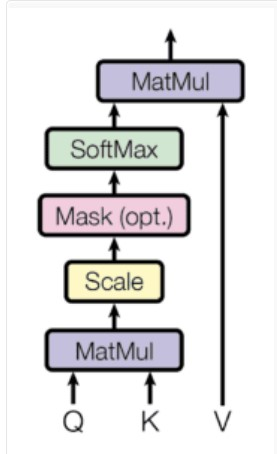

The attention mechanism allows the model to focus on relevant parts of a sentence, helping it understand the context of words.

Key Steps in the Attention Mechanism
Input Processing:

An input sentence (e.g., "The bank of the river was flooded") is fed into the model.
Each word in the sentence is tokenized and converted into an embedding vector.
For each word (or token), three vectors are created by multiplying the embedding vector with three learned matrices:

Query vector (Q)

Key vector (K)

Value vector (V)

Generating Attention Scores:

To determine how much attention each word should pay to other words, the model:
Takes the query vector of the current word (e.g., "bank").
Multiplies it with the key vectors of all other words in the sentence using a dot product to compute attention scores.
A high attention score indicates that a word is highly relevant in the given context (e.g., "river" and "flooded" are highly relevant to "bank" in this example).

Using Attention Scores:

The attention scores are used to weigh the value vectors of the corresponding words.

The model combines the weighted value vectors to produce a context-aware representation of the current word.
For example, in the sentence "The bank of the river was flooded," the attention mechanism helps the model understand that "bank" refers to a river bank and not a financial institution, based on its relationship with "river" and "flooded."
Understanding Query, Key, and Value Matrices

Key Matrix (K):

Learns distinguishing features of each word, helping the model compare words and identify relevant ones.

Query Matrix (Q):

Learns parameters that, when multiplied with key vectors, produce meaningful attention scores.

Value Matrix (V):

Stores foundational knowledge about each word (e.g., meanings of "bank") and is refined by attention scores to produce context-aware word representations.

Purpose of the Attention Mechanism

The attention mechanism allows the model to create a context-aware representation of each word in the sentence.

This helps the model disambiguate words with multiple meanings (like "bank") by focusing on other relevant words in the context.

The final output is a set of refined, context-aware vectors for each word, which the model uses for further tasks like translation or text generation.

### Purpose of the Key Matrix (K)
The Key Matrix (W_K) is a learnable weight matrix in Transformer models.
It transforms token embeddings into key vectors, which help assess the relevance of each word in the sentence.

These key vectors are later used in the attention mechanism to compute attention scores.

### Mathematical Formulation

#### Token Embeddings (X):

Each word in the sentence is represented as an embedding vector (e.g., 3-dimensional).

#### Key Matrix (W_K):

A trainable matrix that enriches the embeddings. For example, we have 3×3 matrix, containing learnable weights.

If word embeddings have 3 values per word, the Key Matrix must also have 3 input columns to properly transform these embeddings.
This ensures that the embedding size aligns with the key transformation.

#### Computing the Key Vector (K) for Each Token:

Multiply the token embedding X by W_K. For each word ( 1 x 3 embedding  we take dot product with W_K which is 3 x 3) to produce K (1 x 3).

The output K is still a 1×3 vector, but now enriched with additional information.

#### Constructing the Final Key Matrix (K)

We compute the key vector for each token in the sentence.
Then, all key vectors are stacked into a final key matrix. Final Key matrix would be of size vocabsize x 3.

Note: Dont confuse W_K with final key matrix K.


### Purpose of Value Matrix

Each word/token in a sentence has a value vector.
These value vectors are derived by multiplying the word embeddings with a trainable weight matrix (W_V).
Unlike keys and queries, which help decide what to focus on, values store the actual meaning of the words.

Example:
If we have a sentence:
📝 "The bank of the river was flooded."

The value vector for "bank" contains information about its meaning, but not its context yet.
The attention scores help decide which meaning is relevant (e.g., "bank" in relation to "river" means a geographical location, not a financial institution).

The query-key dot product only determines which words are important to a given word (attention scores).

However, the model still needs to understand the meaning of words, which is stored in value vectors.

These value vectors are multiplied by attention scores to give a final context-aware representation.

✅ Think of it Like This:

The attention scores (from query-key interaction) tell us where to look.
The value matrix contains the actual information about the words.
Multiplying them filters the word meanings through attention, allowing the model to pick the correct interpretation.





In [15]:
class Head(nn.Module):
    """ Self attention head. This class implements a self-attention mechanism
        which is a key component of transformer-based neural network architectures. """

    def __init__(self):
        super().__init__()  # Initialize the superclass (nn.Module)
        # Embedding layer to convert input token indices to vectors of fixed size (n_embd)
        self.embedding = nn.Embedding(vocab_size, n_embd)

        # Linear layers to compute the queries, keys, and values from the embeddings

        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def attention(self, x):
        embedded_x = self.embedding(x)
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Attention score
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5   # Query * Keys / normalization
        w = F.softmax(w, dim=-1)  # Do a softmax across the last dimesion
        return embedded_x,k,q,v,w

    def forward(self, x):
        embedded_x = self.embedding(x)
        k = self.key(embedded_x)
        q = self.query(embedded_x)
        v = self.value(embedded_x)
        # Attention score
        w = q @ k.transpose(-2, -1) * k.shape[-1]**-0.5   # Query * Keys / normalization
        w = F.softmax(w, dim=-1)  # Do a softmax across the last dimesion
        # Add weighted values
        out = w @ v
        return out

In [16]:
dataset = [
    (1,"Introduction to NLP"),
    (2,"Basics of PyTorch"),
    (1,"NLP Techniques for Text Classification"),
    (3,"Named Entity Recognition with PyTorch"),
    (3,"Sentiment Analysis using PyTorch"),
    (3,"Machine Translation with PyTorch"),
    (1," NLP Named Entity,Sentiment Analysis,Machine Translation "),
    (1," Machine Translation with NLP "),
    (1," Named Entity vs Sentiment Analysis  NLP "),
    (3,"he painted the car red"),
    (1,"he painted the red car")
    ]

In [17]:
tokenizer = get_tokenizer("basic_english")  # Get a basic English tokenizer

In [18]:
def yield_tokens(data_iter):
    """Yield list of tokens in the dataset."""
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])  # Set default index for unknown words

In [19]:
def text_pipeline(x):
    """Converts a text string to a list of token indices."""
    return vocab(tokenizer(x))  # Tokenize the input and map each token to its index in the vocabulary

In [20]:
vocab_size = len(vocab)  # Total number of tokens in the vocabulary
n_embd = 3  # Dimension of the embedding space

# Create the attention head with the integrated embedding layer
attention_head = Head()

In [21]:
# Define the sentence to be tokenized and converted to indices
my_tokens = 'he painted the car red'
# Apply the text pipeline to the sentence to get token indices
input_data = torch.tensor(text_pipeline(my_tokens), dtype=torch.long)

# Print out the shape and the token indices tensor
print(input_data.shape)
print(input_data)

torch.Size([5])
tensor([12, 13, 15, 11, 14])


### Step 1: Embedding
The input consists of token indices for a sentence of size 5.
When passed through an embedding layer, each token is converted into an embedding vector. If the embedding size is 3, the resulting matrix is (5 × 3) (sentence length × embedding size).

### Step 2: Computing Key, Query, and Value
Once we obtain the (5 × 3) embeddings, we compute:

Query (Q)

Key (K)

Value (V)

These are calculated by multiplying embeddings with trainable weight matrices:

Query Weight Matrix (Wq): (3 × 3)

Key Weight Matrix (Wk): (3 × 3)

Value Weight Matrix (Wv): (3 × 3)

Since we dot product the embedding matrix (5 × 3) with Wq, Wk, and Wv (3 × 3),

we get:

Q (5 × 3)

K (5 × 3)

V (5 × 3)

Each row in Q, K, V represents the transformed representation of a word.

### Step 3: Computing Alignment Scores (Attention Weights)

To compute alignment scores (i.e., how much focus one word should give to another), we take:

Query (5 × 3)

Key (5 × 3)

Since matrix multiplication requires matching dimensions, we transpose K to (3 × 5).

Output (5 × 5):

Each row represents a word.

Each column represents the attention score it assigns to every other word. Its word to word relationship.

### Step 4: Applying Softmax Normalization

The computed (5 × 5) attention scores are raw and need to be normalized.
Softmax is applied row-wise, ensuring that scores sum to 1 per row.
This converts scores into a probability distribution, telling us how much attention each word should give to another.


### Summary

Embedding transformation (5 × 3)

Dot product for Q, K, V computation

Dot product for alignment scores (5 × 5)

Softmax normalization of attention scores

In [22]:
# Pass the tokenized input data through the embedding layer and the attention mechanism of the Head class
embedded_x, k, q, v, w = attention_head.attention(input_data)

# Print the size of the resulting embedded vector for verification
print(embedded_x.shape)  # Should show the shape as [number of tokens, embedding dimension]
print("embedded_x:", embedded_x)  # The actual embedded representations of the input tokens

torch.Size([5, 3])
embedded_x: tensor([[ 0.6712,  0.0925, -0.1600],
        [-0.9847,  0.2042,  0.1425],
        [ 0.7190,  0.5606,  0.3414],
        [ 0.1773,  1.9693,  0.8759],
        [ 1.5006,  0.8264, -0.9617]], grad_fn=<EmbeddingBackward0>)


In [23]:
# Print the shapes of the key, query, value, and attention weight matrices
# This helps verify the dimensions are as expected for the attention calculations
print("k:", k.shape)  # The shape of the keys tensor
print("q:", q.shape)  # The shape of the queries tensor
print("v:", v.shape)  # The shape of the values tensor
print("w:", w.shape)  # The shape of the attention weights tensor

k: torch.Size([5, 3])
q: torch.Size([5, 3])
v: torch.Size([5, 3])
w: torch.Size([5, 5])


### Output

The output has the same shape as the original embeddings (5 × 3).
Each row represents a word, but now its embedding is contextually enriched.
Words retain their original dimensions (3) but now include information about related words.

In [24]:
# Now we actually pass the input data through the entire attention head to get the output, this will automatically call forward method
output = attention_head(input_data)

# Print the output and its shape, which should match the shape of the input
# The output tensor contains the final attention-applied representations of the input
print(output.shape)
print(output)

torch.Size([5, 3])
tensor([[-0.2828, -0.0511, -0.3550],
        [-0.2822, -0.1065, -0.3343],
        [-0.2830, -0.0585, -0.3530],
        [-0.2564, -0.0990, -0.3139],
        [-0.2450, -0.0262, -0.3255]], grad_fn=<MmBackward0>)


### Positional Encoding:

Now lets go into detail and see in the architecture where to add positional encoding and why.

#### Key Differences Between RNN and Transformer Models

RNN-based models process words sequentially (word-by-word in order), meaning they inherently understand word positions.

Transformer models process the entire sentence at once, meaning they do not have a built-in understanding of word order.

To compensate for this lack of sequential order, positional encodings are added to word embeddings.

Since Transformers process all words simultaneously, they do not inherently know which word came first, second, etc.

Positional encodings are added to embeddings to provide order information to the model.

These encodings help the model differentiate word positions in a sentence.

### Transformer Model Architecture
#### BERT vs. DistilBERT

Both have the same Transformer architecture but differ in the number of layers.

BERT has 12 Transformer layers, while DistilBERT has 6 layers (making it smaller and faster).

#### Transformer Layer Components

Each layer includes Query (Q), Key (K), Value (V), Multi-Head Attention, Layer Normalization, and Feed-Forward Networks.

Positional encodings are added before passing inputs into the Transformer layers.


### Summary
 - RNNs process words sequentially, so they inherently understand order.
 - Transformers process all words at once, so they require positional encodings to retain word order information.
 - BERT and DistilBERT share the same Transformer architecture, but DistilBERT has fewer layers for efficiency.
 - Positional encodings are added to embeddings before inputting into the
 - Transformer model to ensure the model understands word positions.


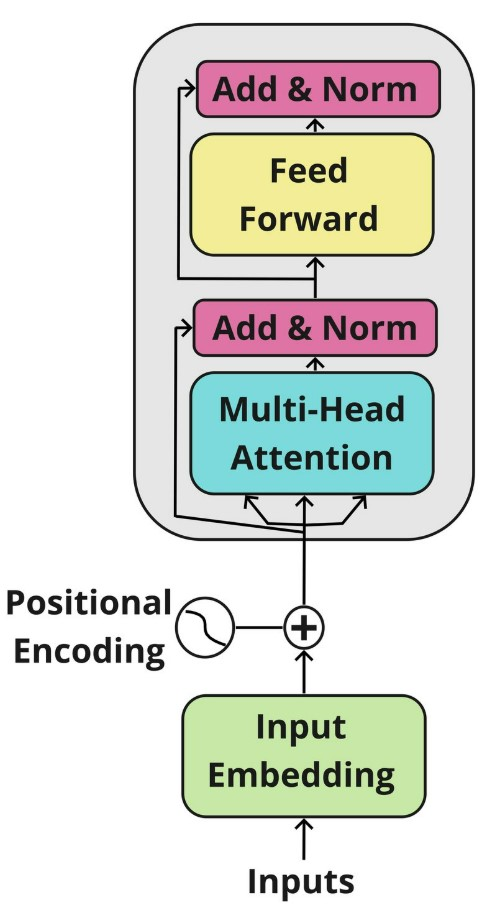

1. Why Do We Need Positional Encodings?

✅ RNN-based models process words sequentially, so they naturally understand order.

✅ Transformers process all words at once, meaning they do not know which word came first.

✅ Positional encodings are added to input embeddings to provide word position information.

 How Are Positional Encodings Added?

Step 1: Convert text into token embeddings (e.g., "I am a robot" → vectors).

Step 2: Create positional encodings (P0, P1, P2, P3) for each word position.

Step 3: Perform element-wise addition of embeddings and positional encodings.

Step 4: The modified position-aware embeddings are now ready for the Transformer layers.


### Setup for Positional Encoding Calculation

Sentence: "I am a robot"

Embedding Dimension (D) = 3 (for simplicity)

In real BERT, D = 768, but that’s too large for manual calculations.

Using N = 5 (a simplification in the formula).

Each word embedding has 3 dimensions, so we must create positional encodings with 3 dimensions.

Sine & Cosine Functions for Even and Odd Indices

The positional encoding formula uses sine for even indices and cosine for odd indices:

 - Even indices (0, 2, 4, ...) → Use Sine function.

 - Odd indices (1, 3, 5, ...) → Use Cosine function.

 Since we use sine and cosine functions, each position in the sequence gets a unique encoding pattern that allows the model to differentiate word positions.

The positional encoding matrix follows this pattern:

 - Row represents a word.

 - Column represents its positional encoding values.



 ```
 Position 0:  [sin(0), cos(0), sin(0), cos(0)]
Position 1:  [sin(1), cos(1), sin(1), cos(1)]
```

This ensures each word position has distinct encoding values while preserving relative order.

1. Why Use Sine and Cosine?

1️⃣ Smooth and Continuous Changes

Sine and cosine waves gradually change values over time.
This helps the model understand the relative positions of words (e.g., "am" is closer to "I" than "robot").
There are no sudden jumps in values, making transitions between words smooth.

✅ Example:

If the sentence is "I am a robot", we want the model to know that "am" is closer to "I" than to "robot".
Sine and cosine functions help maintain this relative spacing.

2️⃣ Repeating Patterns (Periodicity)

Sine and cosine functions repeat over time, meaning they can generalize to longer sentences than seen during training.
Even if a model encounters a sentence longer than any in training, the same
encoding pattern applies.

✅ Example:

A 360° sine/cosine wave repeats itself, meaning even if the input text is very long, the encodings remain consistent.

2. How Are Sine and Cosine Values Used?

 - Each word embedding gets a positional encoding added.
 - The dimensionality of positional encodings must match the embeddings (e.g., if embeddings are 3D, positional encodings must also be 3D).

Sine function is used for even indices, cosine for odd indices.


Why Sine and Cosine for PE?

- Smooth & Continuous → Helps the model recognize gradual positional changes.
- Repeating Patterns → Can extend to long sentences since sine/cosine repeat.
- Encodes Relative Position → Helps the model understand how far apart words are (e.g., "am" comes right after "I" whether it’s in position (2,3) or (52,53)).

How Does the Model Ensure Uniqueness?

- Sine and cosine repeat over time (e.g., at positions 0 and 360, cosine = 1).
- Real models use 784 dimensions (like BERT) instead of just 4 in the example.
- Even if a few numbers repeat, the full 784-dimensional encoding never fully overlaps.
- This creates a unique "fingerprint" for every word position in long sentences.

Why Use High-Dimensional Encodings?

 - Uniqueness → Ensures that even if sine/cosine values repeat, no two positions have the same encoding.
 - Expressiveness → Helps capture subtle word order differences (e.g., "big red ball" vs. "red big ball").
 - Robustness → Works well for long sentences without confusion.

Key Takeaways

✅ PE solves the problem of word order in Transformers.

✅ Sine and cosine functions allow indefinite sentence length handling.

✅ The periodic nature of these functions ensures words have unique positions.

✅ Relative positioning is captured by differences in PE values.

✅ Higher dimensions (e.g., 784 in BERT) prevent overlap and make PEs unique.

1️⃣ Positional Encoding as a Visual Representation

Each position in a sentence has four different encoding values (one for each dimension).

These values are computed using sine and cosine functions.

Example: The word "am" at position 1 has positional encoding values [0.84, 0.54, 0.1, 1.0].

These values uniquely represent its position in the sentence.

2️⃣ Graphical Representation

Each dimension of positional encoding is plotted as a separate colored line:

- Blue → Dimension 0 (sine)
 - Orange → Dimension 1 (cosine)
 - Green → Dimension 2 (sine)
 - Purple → Dimension 3 (cosine)
 - The X-axis represents the position of words in a sentence.
 - The Y-axis represents the encoding value.

3️⃣ Why Do These Lines Look Linear?
 - When zoomed in, the curves appear as straight lines.
 - When zoomed out, they reveal the true sine and cosine wave structure.
 - This confirms that positional encoding values are periodic and repeat over time.

4️⃣ Key Takeaways: Why Sine and Cosine?

✅ 1. Repetition Helps with Long Sentences: The periodic nature of sine and cosine means encodings can be extended infinitely. Even for very long sentences, the model reuses known patterns.

✅ 2. Captures Relative Positions: The difference in values helps the model understand word relationships, not just absolute positions.

✅ 3. Higher Dimensions Ensure Uniqueness: The model avoids confusion because even if some values repeat, the entire multi-dimensional encoding remains unique.

Mathematical Calculation of Positional Encodings:

Positional encodings are computed using sine and cosine functions.
Even indices use the sine function:

PE(pos,2i)=sin(pos/10000^(2i/d))

Odd indices use the cosine function:

PE(pos,2i+1)=cos(pos/10000^(2i/d))

Here, pos is the word's position, i is the dimension index, and d is the embedding dimension.

Tracking the Indices Separately for Sine and Cosine Functions:

Each dimension tracks a separate "wave" of the sine and cosine functions.
This ensures that each position has a unique encoding, even when sine and cosine values repeat.

How the Final Positional Encoding is Computed:

Example for Position 0:

Using sine and cosine formulas, we compute values like:

sin(0) = 0

cos(0) = 1

sin(0) = 0

cos(0) = 1

Example for Position 1:

sin(1) ≈ 0.84

cos(1) ≈ 0.54

sin(1/10) ≈ 0.1

cos(1/10) ≈ 1.0

This process continues for all words in a sequence.

Final Step: Combining Word Embeddings with Positional Encodings

Element-wise Addition:

The computed positional encodings are added to the token embeddings.

Example:

Embedding(I) = [0.9, 0.8, 0.2, 1.0]
Positional Encoding(I) = [0, 1, 0, 1]
Final Representation = [0.9, 1.8, 0.2, 2.0]

This preserves dimensions but modifies values to include positional information.




In [25]:
class PositionalEncoding(nn.Module):

    """Positional encoding module injects some information about the relative or absolute position of the tokens in the sequence."""
    def __init__(self, n_embd, vocab_size, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        # Initialize a buffer for the positional encodings (not a parameter, so it's not updated during training)
        pe = torch.zeros(vocab_size, n_embd)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        # Calculate the positional encodings once in log space
        pe = torch.cat((torch.cos(2 * 3.14 * position / 25), torch.sin(2 * 3.14 * position / 25), torch.sin(2 * 3.14 * position / 5)), 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to each embedding vector assuming x is (seq_len, batch_size, n_embd)
        # Note: 'pe' is a registered buffer and does not require gradients
        pos = x + self.pe[:x.size(0), :]
        return pos

class Head(nn.Module):
    """Self attention head."""
    def __init__(self, n_embd, vocab_size):
        super().__init__()
        # An embedding layer that converts input data (token indices) into dense vectors of fixed size
        self.embedding = nn.Embedding(vocab_size, n_embd)
        # The positional encoding layer
        self.pos_encoder = PositionalEncoding(n_embd, vocab_size)
        # Layers to transform the position-encoded embeddings into queries, keys, and values
        self.key = nn.Linear(n_embd, n_embd, bias=False)
        self.query = nn.Linear(n_embd, n_embd, bias=False)
        self.value = nn.Linear(n_embd, n_embd, bias=False)

    def forward(self, x):
        # Pass the input through the embedding layer to get fixed size dense embeddings
        embedded_x = self.embedding(x)
        # Pass the embeddings through the positional encoder
        p_encoded_x = self.pos_encoder(embedded_x)
        # Generate queries, keys, and values for the attention
        k = self.key(p_encoded_x)
        q = self.query(p_encoded_x)
        v = self.value(p_encoded_x)
        # Calculate the attention scores as the dot product of queries and keys
        w = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5  # Query * Keys / normalization
        # Apply the softmax function to the attention scores to get probabilities
        w = F.softmax(w, dim=-1)
        # Multiply the attention weights with the values to get the output
        out = w @ v
        return out

In the code above, the Head class is an implementation of a self-attention mechanism. It first converts each input token into a dense vector using an embedding layer, and then adds positional information to the vectors using a positional encoding layer. This is done to give the model some information about the position of each token in the input sequence.

Next, the Head class creates three different linear projections (key, query, and value) of the positionally-encoded input data using the nn.Linear layers defined in the __init__ method. These projections are created by multiplying the input data with three different weight matrices.

The attention scores (also known as attention weights) are then computed by taking the dot product of the query and key projections, and then scaling the result by the square root of the key dimension. This is done to stabilize the gradients during training. The softmax function is then applied to these scores to ensure they sum up to 1.

Finally, the output of the attention head is computed by taking a weighted sum of the value projection, where the weights are the attention scores. This output is a weighted sum of the input data, where the weights are determined by the relationships between all pairs of input data points.

In [26]:
# Instantiate the Head class with embedding dimension and vocabulary size as parameters
transformer = Head(n_embd, vocab_size)

# Pass the input data through the transformer model to obtain the output
# This process includes embedding the input, adding positional encodings, and applying self-attention
out = transformer(input_data)

# Print the shape of the output tensor
# The shape will provide insight into how the data has been transformed through the model
print("Output shape:", out.shape)

# Display the output tensor itself
# This output represents the transformed data after applying the embedding, positional encoding, and self-attention mechanisms
print("Output:", out)

Output shape: torch.Size([5, 3])
Output: tensor([[ 0.8884, -0.5239,  0.1513],
        [ 0.1559, -0.0423,  0.5482],
        [ 0.7501, -0.5770,  0.2155],
        [ 0.3667, -0.2284,  0.5789],
        [ 0.2421, -0.1220,  0.4350]], grad_fn=<MmBackward0>)


### Transformers with Multi-head attention using PyTorch

This code block creates an instance of the Transformer model from the nn (neural network) module in PyTorch. The nhead parameter specifies the number of heads in the multi-head attention mechanism, which is a crucial component of the Transformer architecture. In this case, it is set to 16.

The num_encoder_layers parameter determines the number of encoder layers in the Transformer model. Here, it is set to 12.

In [27]:
transformer_model = nn.Transformer(nhead=16, num_encoder_layers=12)

These two lines create random tensors to represent the source and target sequences for the Transformer model.

`src` represents 10 source sequences, each with a length of 32 and a feature dimension of 512.
`tgt` represents 20 target sequences, each with a length of 32 and a feature dimension of 512.
In the context of sequence-to-sequence tasks, the source sequences are the input data (e.g., sentences in one language), and the target sequences are the desired output (e.g., the corresponding sentences in another language).


In [28]:
src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))

Then, pass the source and target tensors through the Transformer model. The out variable will contain the output of the Transformer model, which should have the same shape as the tgt tensor ((20, 32, 512)). This output can be further processed or used for downstream tasks, such as calculating a loss function for training or generating text for inference.


In [29]:
out = transformer_model(src, tgt)

In [30]:
out.shape

torch.Size([20, 32, 512])

## MultiHead attention

`nn.MultiheadAttention` is a module in PyTorch that implements the multi-head self-attention mechanism, a key component of the Transformer architecture. This attention mechanism enables the model to focus on different parts of the input sequence simultaneously, capturing various contextual dependencies and improving the model's ability to process complex natural language patterns.

The `nn.MultiheadAttention` module has three main inputs: `query`, `key`, and `value`  

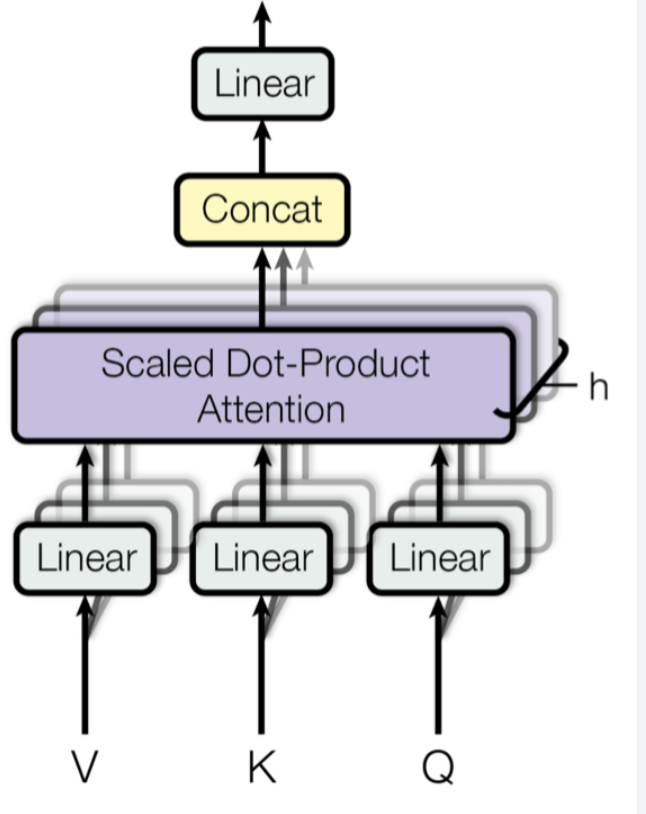

The multi-head attention mechanism works by first splitting the `query`, `key`, and `value` inputs into multiple "heads," each with its own set of learnable weights. This process allows the model to learn different attention patterns in parallel.

The outputs from all heads are concatenated and passed through a linear layer, known as the output projection, to combine the information learned by each head. This final output represents the contextually enriched sequence that can be used in subsequent layers of the Transformer model.


### Key Concepts of Multi-Head Attention

Single Attention Head vs. Multi-Head Attention:

In our example, we focused on a single attention head, which calculates the attention scores for words like river and bank.
In reality, each layer in DistilBERT has 12 attention heads, meaning that instead of just one attention mechanism, there are 12 parallel attention mechanisms per layer.
Stacking Multiple Attention Heads:

Transformers use multiple attention heads to capture different types of relationships between words.
Each word has 12 query vectors, 12 key vectors, and 12 value vectors in each transformer layer.
Since DistilBERT has 6 transformer layers, it has:
12 attention heads per layer
72 attention heads in total (6 × 12)
Why Use Multi-Head Attention?

Each attention head focuses on a different aspect of the input. For example:
One head might focus on grammatical structure.
Another head might track long-distance dependencies in text.
Some heads might capture semantic relationships (e.g., synonyms, related concepts).

This is similar to CNNs in computer vision, where different layers capture edges, textures, and objects.

Layer-Wise Functions in Transformer Models
Each transformer layer has 12 attention heads, and each layer specializes in different tasks:

#### Layer	Function

Layer 1 (Heads 1-12)	Captures basic syntax (subject-verb agreement, sentence parsing).

Layer 2 (Heads 13-24)	Identifies relationships between nouns, verbs, adjectives.

Layer 3 (Heads 25-36)	Understands deeper contextual meanings of words.

Layer 4 (Heads 37-48)	Processes semantic roles (who is doing what in a sentence).

Layer 5 (Heads 49-60)	Manages narrative flow and logical structure of text.

Layer 6 (Heads 61-72)	Handles complex tasks like sentiment analysis, figurative language, or pragmatic cues.

Note: These functions are approximate and learned by the model dynamically during training.


Example: How Multi-Head Attention Works for a Word like "Bank"
Single Attention Head Example:

The word bank (in "The bank of the river was flooded") is assigned a context-aware vector using one attention head.

It focuses on "river" to infer that "bank" refers to a geographical location.
Multi-Head Attention in a Real Transformer:

Instead of one attention head, there are 12 parallel attention heads per layer.

Some attention heads might focus on:

The noun-verb relationship between bank and was.

The semantic relationship between bank and river.

The syntactic structure of the entire sentence.

Thus, each word in the sentence gets 12 different attention-weighted representations per layer, which helps the model understand deeper linguistic structures.

Final Output of Multi-Head Attention
Since each layer has 12 attention heads, the final word representation for "bank" is the concatenation of 12 different outputs.
This gives richer, more context-aware embeddings for each word.


Example:

If sequence length = 6, batch size = 2, and embedding dimension = 4, the input shape would be:

(batch_size=2, seq_len=6, embed_dim=4)
Example:

```
[
  [[1.2, 3.4, 5.6, 7.8],   # Word 1 embedding
   [2.1, 4.3, 6.5, 8.7],   # Word 2 embedding
   [1.0, 2.0, 3.0, 4.0],   # Word 3 embedding
   [0.5, 0.8, 1.2, 1.5],   # Word 4 embedding
   [3.3, 2.2, 1.1, 0.9],   # Word 5 embedding
   [4.4, 3.3, 2.2, 1.1]],  # Word 6 embedding

  [[2.5, 3.5, 4.5, 5.5],   # Word 1 embedding (2nd sentence)
   [1.1, 2.2, 3.3, 4.4],   # Word 2 embedding
   [5.0, 4.0, 3.0, 2.0],   # Word 3 embedding
   [7.0, 6.0, 5.0, 4.0],   # Word 4 embedding
   [2.2, 3.3, 4.4, 5.5],   # Word 5 embedding
   [6.6, 5.5, 4.4, 3.3]]   # Word 6 embedding
]

```

Step 1: Splitting into Heads

The input embedding (size 4) is split into 2 attention heads of size 2 each.

Step 2: Attention Calculation

Each head independently calculates attention weights and updates the embeddings.

Step 3: Concatenation & Output

The attention outputs from both heads are concatenated and projected back to size (seq_len, batch_size, 4).

In [32]:

# Embedding dimension
embed_dim = 4
# Number of attention heads
num_heads = 2
print("should be zero:",embed_dim %num_heads)
# Initialize MultiheadAttention
multihead_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads,batch_first=False)

should be zero: 0


In [33]:
seq_length = 10 # Sequence length
batch_size = 5 # Batch size
query = torch.rand((seq_length, batch_size, embed_dim))
key = torch.rand((seq_length, batch_size, embed_dim))
value = torch.rand((seq_length, batch_size, embed_dim))
# Perform multi-head attention
attn_output, _= multihead_attn(query, key, value)
print("Attention Output Shape:", attn_output.shape)

Attention Output Shape: torch.Size([10, 5, 4])
